In [ ]:
import numpy as np
import math
import random

import matplotlib.pyplot as plt
import matplotlib.image as mb_im


from sklearn.datasets import load_digits


import keras
keras.backend.set_floatx('float64')

from keras.activations import relu
from keras.losses import CategoricalCrossentropy
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
CCE = CategoricalCrossentropy()

from scipy.special import softmax


In [ ]:
digits = load_digits()

image_dataset = digits.images
image_label = digits.target

random_img_indices = random.sample(range(0, len(image_dataset))  , k = 1797  )

In [ ]:

ori_h, ori_w = image_dataset[0].shape
ori_c = 1

lb.fit(image_label[:10])


X = image_dataset[random_img_indices[0]].reshape(1,ori_h, ori_w, ori_c)
Y = lb.transform( [image_label[random_img_indices[0]]     ] ).reshape(1,-1)



for ri in random_img_indices[1: ]:

  X = np.vstack((X, image_dataset[  random_img_indices[ri]                 ].reshape(1,ori_h, ori_w, ori_c)   ))

  Y = np.vstack((Y, lb.transform( [ image_label[random_img_indices[ri]]    ] ).reshape(1,-1) ))

In [ ]:
X.shape, Y.shape

((1797, 8, 8, 1), (1797, 10))

In [ ]:

def yield_single_image(X_dataset):

  for each_ind, each_image in enumerate(X_dataset):
    yield (each_ind, each_image)

def yield_image_patch(inp_im , im_h, im_w, fh, fw, im_c = 1,
                      sh=1, sw=1, pad_h = 1, pad_w = 1,
                      op = "convolution" ):
  
  """ This function yields a patch of single image, based on filter dimensions, to perform convolution operation  """

  
  
    
  it_h = int(1 + (im_h - fh) / sh)

  it_w = int(1 + (im_w - fw) / sw)

  
  for h in range(it_h):
    for w in range(it_w):
      
      yield (h,w, inp_im[h*sh: (h*sh) + fh,
                        w*sw : (w*sw) + fw] )

def relu_derivative(A):
  A[A<=0] = 0
  A[A>0] = 1
  return A

In [ ]:
class My_Conv2D:

  def __init__(self, num_feature_maps = 7, filter_size = 7, stride = (1,1),
               padding = 'VALID', padding_size = None, input_shape = None ):
    

    """ 
    This class performns convolution operation, without any activation applied on it, on an entire data set,
     this class provides both forward and back ward propogation implementations.
     
     This class only supports square filter and stride shapes for time being, also the input shape should be 4D in following format,
     (num_samples, input_height, input_width, input_channels).


      """

    self.num_feature_maps = num_feature_maps

    self.fh, self.fw = filter_size, filter_size

    self.stride_h, self.stride_w = stride


    # If padding is 'valid' then it means no padding
    if padding == 'VALID':

      # Setting padding height and width
      self.pad_h, self.pad_w = 0,0

    
    elif padding == 'SAME':

      # Setting padding height and width
      self.pad_h , self.pad_w = padding_size, padding_size


    # If input shape is already provided
    if input_shape:

      #Assumed to be 4D
      self.input_shape = input_shape

      self._initialize_placeholders()
      

    # If input shape is not provided yet, we don't have enough info to create filter weights
    else:
      pass
  
  def _initialize_placeholders(self, mode = "forward"):

    """ Function to initialize required filter and convolution output placeholder variables, this function can be used to initialize both
    forward and backward propogation placeholders.  """

    if mode == "forward":

      # Getting required variables from input shape tuple
      self.num_samples, self.ih, self.iw, self.ic = self.input_shape

      # Calculating output shape after convolution operation
      o_height = int(  (self.ih - self.fh + 2*self.pad_h ) / self.stride_h   ) + 1
      o_width  = int(  (self.iw - self.fw + 2*self.pad_w ) / self.stride_w   ) + 1

      # Setting convolution height, width and no. of feature maps
      self.co_h , self.co_w, self.co_fm = o_height, o_width, self.num_feature_maps


      # A filter of a convolution layer is always 4D - (filter height, filter width, no.of input channels, no.of output feature maps)
      # Defining based on hyper parameters and normalizing filter values
      self.filter = np.random.randn(self.fh, self.fw, self.ic , self.num_feature_maps) / (self.fh * self.fw)


      # A convolution output for a single image is always 4D if num of samples are given
      self.conv_out = np.zeros(shape = (self.num_samples, self.co_h, self.co_w, self.co_fm) , dtype = np.float32)


    else:

      
      filter_placeholder = np.zeros(shape = (self.fh, self.fw, self.ic, self.num_feature_maps ))

      incoming_image_placeholder = np.zeros(shape = (self.num_samples, self.ih, self.iw, self.ic))
      
      # Returning placeholders for holding filter and input derivatives w.r.t this layer
      return (filter_placeholder,
              incoming_image_placeholder)

  def _yield_image_patch(self, input_image):

    
    # n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    # n_W = int((n_W_prev - f + 2 * pad) / stride) + 1


    it_h = int( (self.ih - self.fh + (2*self.pad_h) ) / self.stride_h ) + 1

    it_w = int( (self.iw - self.fw + (2*self.pad_w) ) / self.stride_w ) + 1

      
    for h in range(it_h):
      for w in range(it_w):

        height_start = h * self.stride_h; height_end = height_start + self.fh
        width_start = w * self.stride_w ; width_end = width_start + self.fw

        # Yielding single image, of the shape of filter dimensions and all channels 
        yield (h,w, input_image[height_start: height_end,
                          width_start:width_end, : ] )

  def forward_prop(self, dataset ):

    # Filter has already been defined, continue with normal convolution operation
    if 'filter' in self.__dict__ and 'conv_out' in self.__dict__:
      pass


    # We still don't know the no. of channels for image, so we have to initialize the filter first with proper channels before training
    else:
      
      # dataset has 4D here ( m, h, w, c)
      if len(dataset.shape) > 3:
        self.input_shape = dataset.shape
        
      else:
        num_samp, im_h, im_w = input_image.shape; im_c = 1
        dataset = dataset.reshape(num_samp, imh_h, im_c, im_c)

        self.input_shape = (num_samp, im_h, im_w, im_c)
      
      # Initialize filter weights and other placeholder variables
      self._initialize_placeholders()

    
    self.dataset = dataset

    for img_ind , input_image in yield_single_image(self.dataset):

      for h, w, image_patch in self._yield_image_patch(input_image = input_image ):

        for feat_map in range(self.num_feature_maps):
  
          self.conv_out[ img_ind , h, w, feat_map] = np.sum(   image_patch * self.filter[: , : , : , feat_map]  )
          
  def backward_prop(self, DL_nextL, learning_rate):

    """ This function computes back-propogation values w.r.t the filter of this particular convolution layer. 

    This function assumes that back propogation for layers after this were already computed.
     """
    
    # Returns a numpy array of zeros with proper shape for filter 
    self.DL_filter, self.DL_input = self._initialize_placeholders(mode = "backward")


    # For each image in entire dataset
    for each_image_ind, each_image in yield_single_image(self.dataset):
      
      for h, w, each_im_patch in self._yield_image_patch(input_image = each_image ):
        
        for each_feat_map in range(self.num_feature_maps):
         
          
          self.DL_filter[:, : , :, each_feat_map] += ( each_im_patch * DL_nextL[each_image_ind, h, w, each_feat_map] )

          self.DL_input[each_image_ind,
                        h*self.stride_h : h*self.stride_h + self.fh,
                        w*self.stride_w : w*self.stride_w + self.fw ,
                        :  ] += ( DL_nextL[each_image_ind,h,w,each_feat_map] * self.filter[: , : , : , each_feat_map ])


    self.DL_filter /= self.num_samples
    
    # Update the weights using an optimizer
    self.filter -= (learning_rate * self.DL_filter)

    


In [ ]:
class My_Pooling:

  def __init__(self, pool_size = 2, stride = 1, pool_type = "Max", padding = 'valid'):

    self.ph, self.pw = pool_size, pool_size

    self.stride_h, self.stride_w = stride

  def _initialize_placeholders(self, mode = "forward"):

    """ Function to initialize required filter and convolution output placeholder variables  """


    if mode == "forward":

      self.num_samples, self.ih, self.iw, self.ic = self.input_shape

      # n_H = int(1 + (n_H_prev - f) / stride)
      # n_W = int(1 + (n_W_prev - f) / stride)
      # n_C = n_C_prev

      o_H = int(  (self.ih - self.ph  ) / self.stride_h   ) + 1

      o_W = int(  (self.iw - self.pw  ) / self.stride_w   ) + 1

      o_C = self.ic

      self.pool_out_h , self.pool_out_w, self.pool_out_c = o_H, o_W, o_C

      # A convolution output for a single image is always 4D if num of samples are given
      self.pool_out = np.zeros(shape = (self.num_samples, self.pool_out_h , self.pool_out_w, self.pool_out_c) , dtype = np.float32)


    else:
      return np.zeros(shape = (self.num_samples, self.ih, self.iw, self.ic ))


  def _yield_image_patch(self, input_image):

    # This might also has to change, but not necessarily
    it_H = int(  (self.ih - self.ph  ) / self.stride_h   ) + 1

    it_W = int(  (self.iw - self.pw  ) / self.stride_w   ) + 1;
    
    it_C = self.ic

      
    for h in range(it_H):
      for w in range(it_W):
        for c in range(it_C):

          # Test with this height start, width start calc, if perf don't improve
          # Change to vert_start = h; vert_end = h+f; horiz_start = w; horiz_end = w+f

          height_start = h * self.stride_h; height_end = height_start + self.ph
          width_start = w * self.stride_w ; width_end = width_start + self.pw

          # New Approach
          # height_start = h ; height_end = h + self.ph
          # width_start = w ; width_end = w + self.pw



        # Yielding single image, of the shape of filter dimensions and all channels 
          yield (h,w,c, input_image[height_start: height_end,
                          width_start:width_end, c ] )


  def max_forward(self):
    pass

  def max_backward(self):
    pass

  def average_forward(self, dataset):

    # Input data to this layer
    self.dataset = dataset

    # Assuming this to be already in 4D, and first dimension for no. of samples
    self.input_shape = self.dataset.shape

    # Intializes required placeholders as class level variables
    self._initialize_placeholders()

  
    for img_ind , input_image in yield_single_image(self.dataset):

      for h, w, feat_map, image_patch in self._yield_image_patch(input_image = input_image):

        self.pool_out[ img_ind , h, w, feat_map] = np.mean( image_patch )


  def average_backward(self, DL_nextL):

    # Intializes required placeholders as class level variables
    self.DL_prev_Layer = self._initialize_placeholders(mode = "backward") # (m, dataset_height, dataset_width, dataset_feat_map)


    for img_ind , input_image in yield_single_image(DL_nextL):

      for h, w,feat_map, image_patch in self._yield_image_patch(input_image = input_image):
        
        distribute_val = DL_nextL[img_ind, h,w,feat_map] / (self.ph*self.pw);

        a = np.ones(shape = (self.ph, self.pw ) ) * distribute_val  

        self.DL_prev_Layer[ img_ind , (h*self.stride_h): (h*self.stride_h) + self.ph,
                                      (w*self.stride_w) : (w*self.stride_w) + self.pw ,
                            feat_map] +=  a

      


    # No Updates required for this step

In [ ]:
# run_epochs = int(input("Please enter no. of epochs : "))

# learning_rate = float(input("Please enter no. of epochs : "))


run_epochs = 400

learning_rate = 1e-2


img_feat = 27; num_outs = 10; num_samples = X.shape[0]

Weights = np.random.rand(num_outs, img_feat ) * np.sqrt(1/(num_outs + img_feat))

Conv_Layer = My_Conv2D(num_feature_maps=3, filter_size=5, stride = (1,1), input_shape=(1797,8,8, 1))

Pool_Layer = My_Pooling(pool_size = 2, stride = (1,1), pool_type = "Avergae")




In [ ]:
My_Losses = []


for i in range(run_epochs):

  Conv_Layer.forward_prop(dataset= X )
  Z1 = Conv_Layer.conv_out

  A1 = relu(Z1).numpy()

  Pool_Layer.average_forward(dataset= A1 )
  Z2 = Pool_Layer.pool_out

  A2 = Z2.reshape(1797, -1)


  Z3 = np.dot(Weights, A2.T)
  A3 = softmax(Z3, axis = 0)

  loss = CCE(Y,A3.T ).numpy()

  My_Losses.append(loss)


  # Backward

  if i %20 == 0:
    print("Loss at epoch: {} is: {}".format(i, loss))




  ## BACKWARD PROPOGATION
  DL_Z3 = A3.T - Y
  DL_Weights = DL_Z3.T.dot(A2)
  
  DL_A2 = DL_Z3.dot(Weights)
  DL_Z2 = DL_A2.reshape(Z2.shape)
  

  Pool_Layer.average_backward(DL_nextL= DL_Z2)
  DL_A1 = Pool_Layer.DL_prev_Layer


  DL_Z1 = DL_A1 * relu_derivative(Z1)

  Conv_Layer.backward_prop(DL_nextL= DL_Z1, learning_rate = learning_rate)
  Weights -= learning_rate * (DL_Weights / num_samples)


Loss at epoch: 0 is: 2.3192756175994873
Loss at epoch: 20 is: 2.2082409858703613
Loss at epoch: 40 is: 1.987061619758606
Loss at epoch: 60 is: 1.5277098417282104
Loss at epoch: 80 is: 1.0526002645492554
Loss at epoch: 100 is: 0.7638491988182068
Loss at epoch: 120 is: 0.6031661033630371
Loss at epoch: 140 is: 0.5073283910751343
Loss at epoch: 160 is: 0.4442830979824066
Loss at epoch: 180 is: 0.39931055903434753
Loss at epoch: 200 is: 0.3651742935180664
Loss at epoch: 220 is: 0.33817368745803833
Loss at epoch: 240 is: 0.3160955011844635
Loss at epoch: 260 is: 0.29763540625572205
Loss at epoch: 280 is: 0.2819855511188507
Loss at epoch: 300 is: 0.268539160490036
Loss at epoch: 320 is: 0.2568622827529907
Loss at epoch: 340 is: 0.24664486944675446
Loss at epoch: 360 is: 0.23762474954128265
Loss at epoch: 380 is: 0.22960610687732697


In [ ]:
DL_Z3.shape, A2.shape

((1797, 10), (1797, 27))

In [ ]:
import keras
keras_model = keras.Sequential()

keras_model.add(keras.layers.Conv2D(filters= num_filters, kernel_size= (fil_h,fil_w),strides = (1,1), activation= "relu",
                                    input_shape = (8,8,1), padding  = 'valid',use_bias = False  ))

keras_model.add(keras.layers.AveragePooling2D(pool_size=(,),strides=(1,1), padding = 'valid'))

keras_model.add(keras.layers.Flatten())

keras_model.add(keras.layers.Dense(num_outs,
                                   activation= "softmax",use_bias=False))

keras_model.summary() 

optimizer = keras.optimizers.SGD(learning_rate=1e-2, nesterov=False)

keras_model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])






Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 3)           75        
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 3)           0         
_________________________________________________________________
flatten (Flatten)            (None, 27)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                270       
Total params: 345
Trainable params: 345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keras_model.fit(x=X,y=Y,epochs=run_epochs)

Epoch 1/400
57/57 [==============================] - 0s 1ms/step - loss: 2.2628 - accuracy: 0.1937
Epoch 2/400
57/57 [==============================] - 0s 1ms/step - loss: 2.0495 - accuracy: 0.2421
Epoch 3/400
57/57 [==============================] - 0s 2ms/step - loss: 1.8123 - accuracy: 0.3400
Epoch 4/400
57/57 [==============================] - 0s 1ms/step - loss: 1.2986 - accuracy: 0.5587
Epoch 5/400
57/57 [==============================] - 0s 2ms/step - loss: 0.9168 - accuracy: 0.7095
Epoch 6/400
57/57 [==============================] - 0s 2ms/step - loss: 0.6970 - accuracy: 0.7819
Epoch 7/400
57/57 [==============================] - 0s 1ms/step - loss: 0.5590 - accuracy: 0.8258
Epoch 8/400
57/57 [==============================] - 0s 1ms/step - loss: 0.4880 - accuracy: 0.8453
Epoch 9/400
57/57 [==============================] - 0s 1ms/step - loss: 0.4255 - accuracy: 0.8726
Epoch 10/400
57/57 [==============================] - 0s 1ms/step - loss: 0.3767 - accuracy: 0.8843
Epoch 11/

In [ ]:
A3[:, 0]

array([2.54136155e-04, 1.30641107e-02, 3.55575214e-04, 2.38883405e-02,
       8.59348677e-07, 4.16441191e-04, 1.65036762e-07, 1.15031086e-05,
       6.19909768e-03, 9.55809771e-01])

In [ ]:
Y[0, :]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

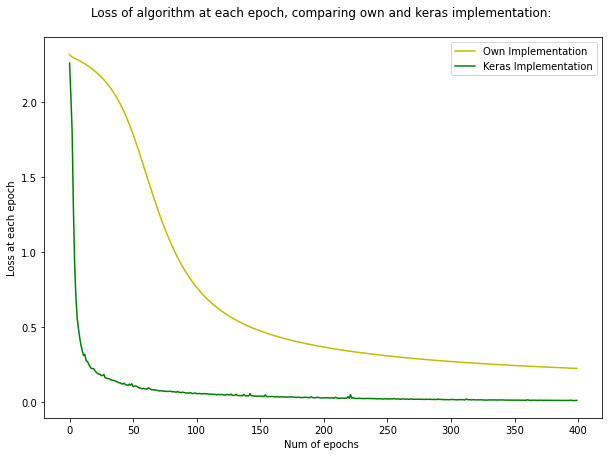

In [ ]:

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(My_Losses, color = 'y')
plt.plot(keras_model.history.history["loss"], color = 'g')
plt.legend(["Own Implementation", "Keras Implementation"])
plt.title("Loss of algorithm at each epoch, comparing own and keras implementation: \n")
plt.xlabel("Num of epochs ")
plt.ylabel("Loss at each epoch")

plt.show()

